# **CarND-Vehicle-Detection** 
***


---

In [1]:
"""
Identify vehicles in a video from a front-facing camera on a car. 
Programm: Udacity - Self-Driving Car Engineer
Project: P5 - CarND-Vehicle-Detection
Author: Daniel Gattringer (gada1982) 
mail: daniel@gattringer.biz
"""

'''
CODE CELL 1
'''

# Import required packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time
import pickle
import os
%matplotlib inline


In [2]:
'''
CODE CELL 2
'''

'''
This function 
RETURN:
         
'''
def get_car_data():
    # Define path where training data with vehicles images are stored
    path_car_images = 'training_data/vehicles/'
    # Get GIT_Far-images
    car_images_GTI_Far = glob.glob(path_car_images + 'GTI_Far/*.png')
    # Get GTI_Left-images
    car_images_GTI_Left = glob.glob(path_car_images + 'GTI_Left/*png')
    # Get GTI_MiddleClose-images
    car_images_GTI_MiddleClose = glob.glob(path_car_images + 'GTI_MiddleClose/*.png')
    # Get GTI_Right-images
    car_images_GTI_Right = glob.glob(path_car_images + 'GTI_Right/*.png')
    # Get KITTI_extracted-images
    car_images_KITTI_extracted = glob.glob(path_car_images + 'KITTI_extracted/*.png')
    car_images = np.concatenate(( car_images_GTI_Far, car_images_GTI_Left, car_images_GTI_MiddleClose, car_images_GTI_Right, car_images_KITTI_extracted))
    return car_images
    
'''
This function 
RETURN:
         
'''
def get_non_car_data():
    # Define path where training data with non-vehicles images are stored
    path_non_car_images = 'training_data/non-vehicles/'
    
    non_car_images_extras = glob.glob(path_non_car_images + 'Extras/*.png')
    non_car_images_GTI = glob.glob(path_non_car_images + 'GTI/*.png')
    non_car_images = np.concatenate((non_car_images_extras,non_car_images_GTI))
    return non_car_images

car_images = get_car_data()
non_car_images = get_non_car_data()

print('Number of car-images: ', len(car_images))
print('Number of non-car-images: ', len(non_car_images))



Number of car-images:  8792
Number of non-car-images:  8968


In [3]:
# Helper function out of lectures

'''
This function 
RETURN:
         
'''  
def bin_spatial(img, size):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features
'''
This function 
RETURN:
         
'''
def color_hist(img, hist_bins, bins_range):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], hist_bins, bins_range)
    channel2_hist = np.histogram(img[:, :, 1], hist_bins, bins_range)
    channel3_hist = np.histogram(img[:, :, 2], hist_bins, bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


'''
This function 
RETURN:
         
'''
def convert_color_space(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    
    return feature_image


'''
This function 
RETURN:
         
'''
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [4]:
def get_parameters_hog_features():
    cspace = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    
    return cspace, orient, pix_per_cell, cell_per_block, hog_channel

def get_parameters_color_features():
    cspace = 'YCrCb'
    spatial_size = (32,32)
    hist_bins = 32
    hist_range = (0, 256)
    
    return cspace, spatial_size, hist_bins, hist_range

In [5]:




#Extract Iimage features TODO rework
def extract_features(images, cspace, spatial_size, hist_bins, 
                     orient, pix_per_cell, cell_per_block, hog_channel):
    features = []
    for img in images:
        image = mpimg.imread(img)
        img_features = []
        
        #Convert Color
        feature_image = convert_color_space(image, cspace=cspace)
            
        
        img_features.append(bin_spatial(feature_image, spatial_size))
            
        
        hist_features = color_hist(feature_image, hist_bins, bins_range=(0,256))
        img_features.append(hist_features)
            
        #HOG Features
        if hog_channel == 'ALL':
            hog_feature = []
            for channel in range(feature_image.shape[2]):
                hog_feature.append(get_hog_features(feature_image[:, :, channel], orient, pix_per_cell,
                                                   cell_per_block, vis=False, feature_vec=True))
            hog_feature = np.ravel(hog_feature)
        else:
            hog_feature = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell,
                                          cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_feature)
        features.append(np.concatenate(img_features))
        
    return features


'''
This function 
RETURN:
         
'''
def extract_car_features():
    
    # Extract color-features for car-images
    cspace, spatial_size, hist_bins, hist_range = get_parameters_color_features()
    cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()
    t1 = time.time()
    features = extract_features(car_images, cspace, spatial_size, hist_bins, 
                                orient, pix_per_cell, cell_per_block, hog_channel)
    t2 = time.time()
    print(round(t2 - t1, 2), 'Seconds to extract features (COLOR and HOG) for car-images...')
    
    return features

'''
This function 
RETURN:
         
'''
def extract_non_car_features():
    
    # Extract color-features for non-car-images
    cspace, spatial_size, hist_bins, hist_range = get_parameters_color_features()
    cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()
    t1 = time.time()
    features = extract_features(non_car_images, cspace, spatial_size, hist_bins, 
                                orient, pix_per_cell, cell_per_block, hog_channel)
    t2 = time.time()
    print(round(t2 - t1, 2), 'Seconds to extract features (COLOR and HOG) for non-car-images...')
     
    return features


car_features = extract_car_features()
non_car_features = extract_non_car_features()

print('Number of car-features: ', len(car_features))
print('Number of non-car-features: ', len(non_car_features))

31.79 Seconds to extract features (COLOR and HOG) for car-images...
31.31 Seconds to extract features (COLOR and HOG) for non-car-images...
Number of car-features:  8792
Number of non-car-features:  8968


Number of car-features:  8792
Number of non-car-features:  8968


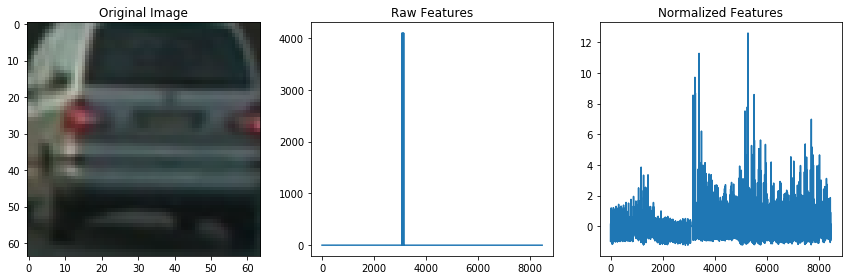

In [6]:
# Get training data (normalize the feature vectores)

print_info = 1

'''
This function 
RETURN:
         
'''
def get_training_data(car_features, non_car_features, car_images, non_car_images, print_info):
    # Get array with training data
    print('Number of car-features: ', len(car_features))
    print('Number of non-car-features: ', len(non_car_features))
    X = np.vstack((car_features, non_car_features)).astype(np.float64)
    # Normalize features (training data)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # Set labels
    y = np.concatenate((np.ones(len(car_images)), np.zeros(len(non_car_images))))
    
    if print_info == 1:
        car_ind = np.random.randint(0, len(car_images))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(car_images[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    
    return scaled_X, y, X_scaler

scaled_X, y, X_scaler = get_training_data(car_features, non_car_features, car_images, non_car_images, print_info)

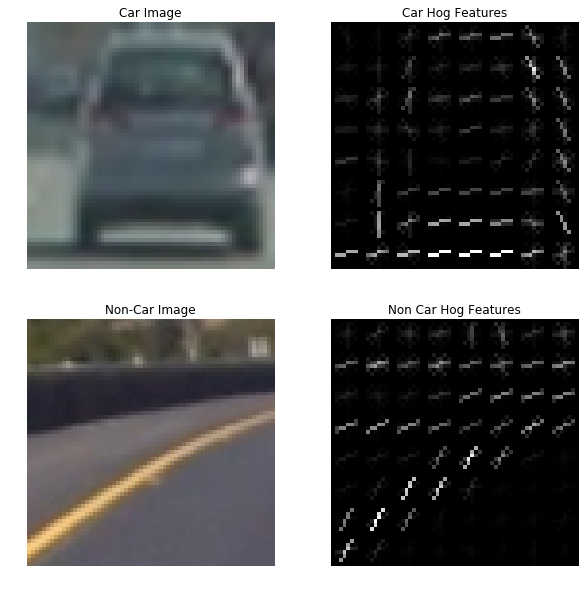

In [7]:
# Print HOG examples

'''
This function 
RETURN:
         
'''
def print_hog_examples():
    
    cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()
    car_image = mpimg.imread(car_images[np.random.randint(1,10)])
    car_features, car_hog = get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    non_car_image = mpimg.imread(non_car_images[np.random.randint(1,10)])
    noncar_features, noncar_hog = get_hog_features(non_car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.subplot(221).set_title('Car Image')
    plt.subplot(221).axis('off')
    plt.imshow(car_image)
    plt.subplot(222)
    plt.subplot(222).set_title('Car Hog Features')
    plt.subplot(222).axis('off')
    plt.imshow(car_hog, cmap='gray')
    plt.subplot(223)
    plt.subplot(223).set_title('Non-Car Image')
    plt.subplot(223).axis('off')
    plt.imshow(non_car_image)
    plt.subplot(224)
    plt.subplot(224).set_title('Non Car Hog Features')
    plt.subplot(224).axis('off')
    plt.imshow(noncar_hog, cmap='gray')
    
print_hog_examples()

In [8]:
# Split training and test data

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.20, random_state = 0)

In [10]:
# Train classiefier

svc = LinearSVC()

svc.fit(X_train, y_train)

accuracy = round(svc.score(X_test, y_test), 4)

print ('Accuracy: ', accuracy)

Accuracy:  0.9896


In [11]:
# Save as pickle

def save_as_pickle(file_name, svc, X_scaler):
    cspace, spatial_size, hist_bins, hist_range = get_parameters_color_features()
    cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()
    
    if not os.path.isfile(file_name):
        print('Saving SVC relevant data to pickle file...')
        try:
            with open(file_name, 'wb') as pfile:
                pickle.dump(
                {
                    'svc': svc,
                    'x_scaler' : X_scaler,
                    'color_space': cspace,
                    'spatial_size': spatial_size,
                    'hist_bins': hist_bins,
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
                    'hog_channel': hog_channel
                },
                pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Error while saving pickle file.', file_name, ':', e)
            raise

    print('Data for SVC saved as pickle file.')
    
file_name = 'SVC_cars.p'
save_as_pickle(file_name, svc, X_scaler)

Data for SVC saved as pickle file.


In [12]:
# Go further after this checkpoint

# Import required packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time
import pickle
import os
%matplotlib inline

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        pickle_data = pickle.load(f)
        svc = pickle_data['svc']
        X_scaler = pickle_data['x_scaler']
        cspace = pickle_data['color_space']
        spatial_size = pickle_data['spatial_size']
        hist_bins = pickle_data['hist_bins']
        orient = pickle_data['orient']
        pix_per_cell = pickle_data['pix_per_cell']
        cell_per_block = pickle_data['cell_per_block']
        hog_channel = pickle_data['hog_channel']
        del pickle_data

    print('Data for SVC loaded.')
    
    return svc, X_scaler, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel  

file_name = 'SVC_cars.p'
svc, X_scaler, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel = read_pickle(file_name)

Data for SVC loaded.


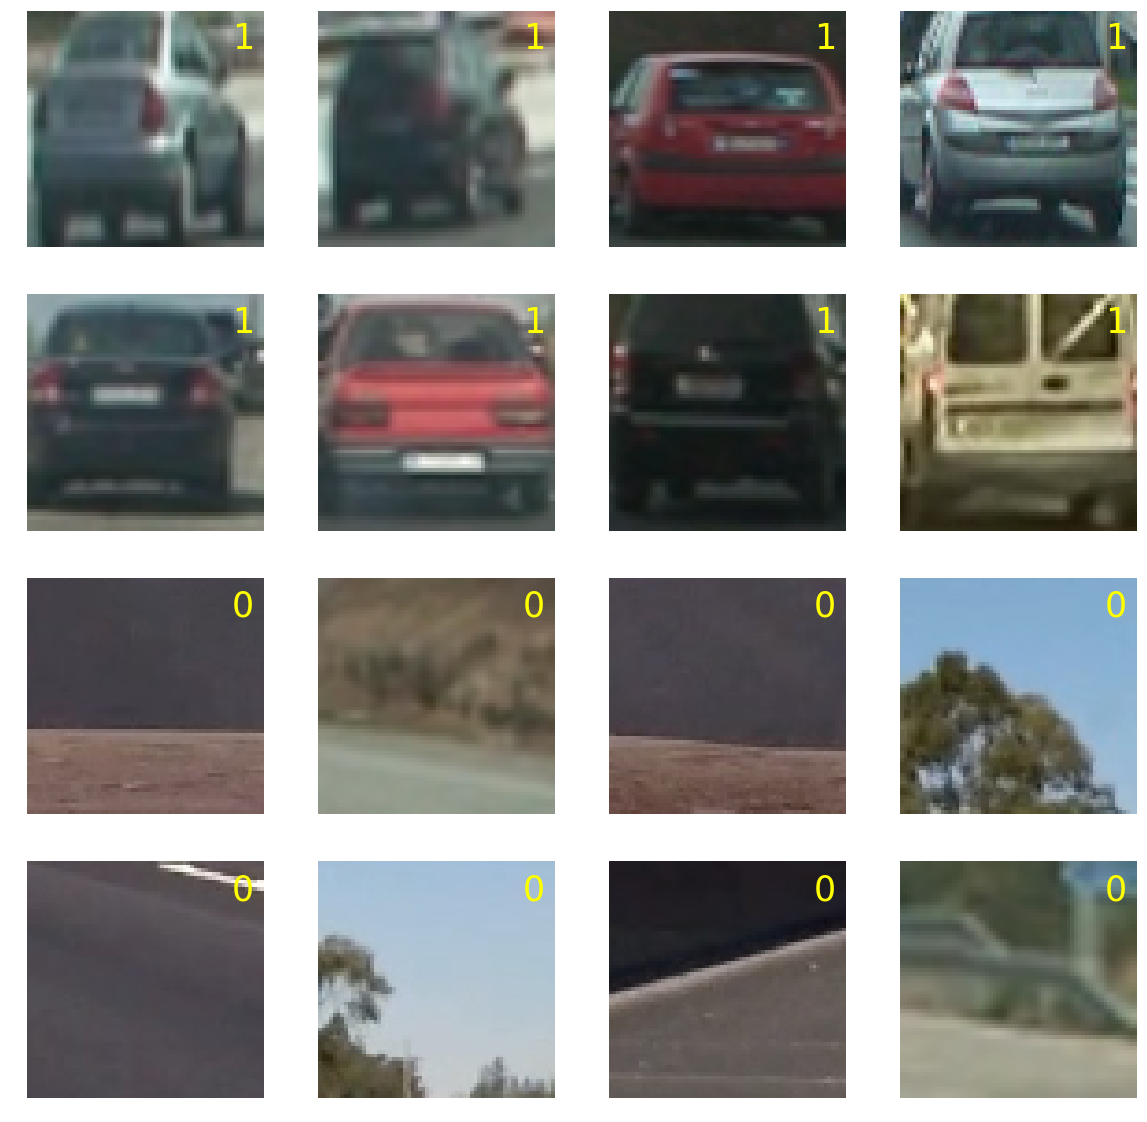

In [41]:
def get_prediction_of_single_image(image):
    cspace, spatial_size, hist_bins, hist_range = get_parameters_color_features()
    cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()
    
    # Extract features for that image
    features = extract_features_single(image, cspace, spatial_size, hist_bins, 
                                  orient, pix_per_cell, cell_per_block, hog_channel)
    # Scale extracted features to be fed to classifier
    test_features = X_scaler.transform(np.array(features).reshape(1, -1))
    # Predict using your classifier
    prediction = svc.predict(test_features)
    
    return prediction


def show_labeled_images_as_table():
    index_list = []
    for i in range(0, 8):
        path = 'test_images/small/car' + str(i + 1) + '.png'
        index_list.append(path)
    for i in range(8, 16):
        path = 'test_images/small/non_car' + str(i - 7) + '.png'
        index_list.append(path)
    
    
    dummy, axis = plt.subplots( 4, 4, figsize=(20,20))
    
    columns = 0
    rows = 0
    old_row = 0
    count = 0
    for x in index_list:
        image = mpimg.imread(x)
        
        if columns == 3:
            rows += 1
        columns = count % 4
        count += 1
        
        axis[rows, columns].imshow(image)
            
        label = get_prediction_of_single_image(image)
        axis[rows, columns].annotate(int(label), xy=(55, 10), color='yellow', fontsize='35')
        
        axis[rows,columns].axis('off')
        
    plt.show()
    
           
show_labeled_images_as_table()

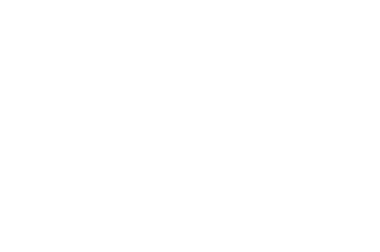

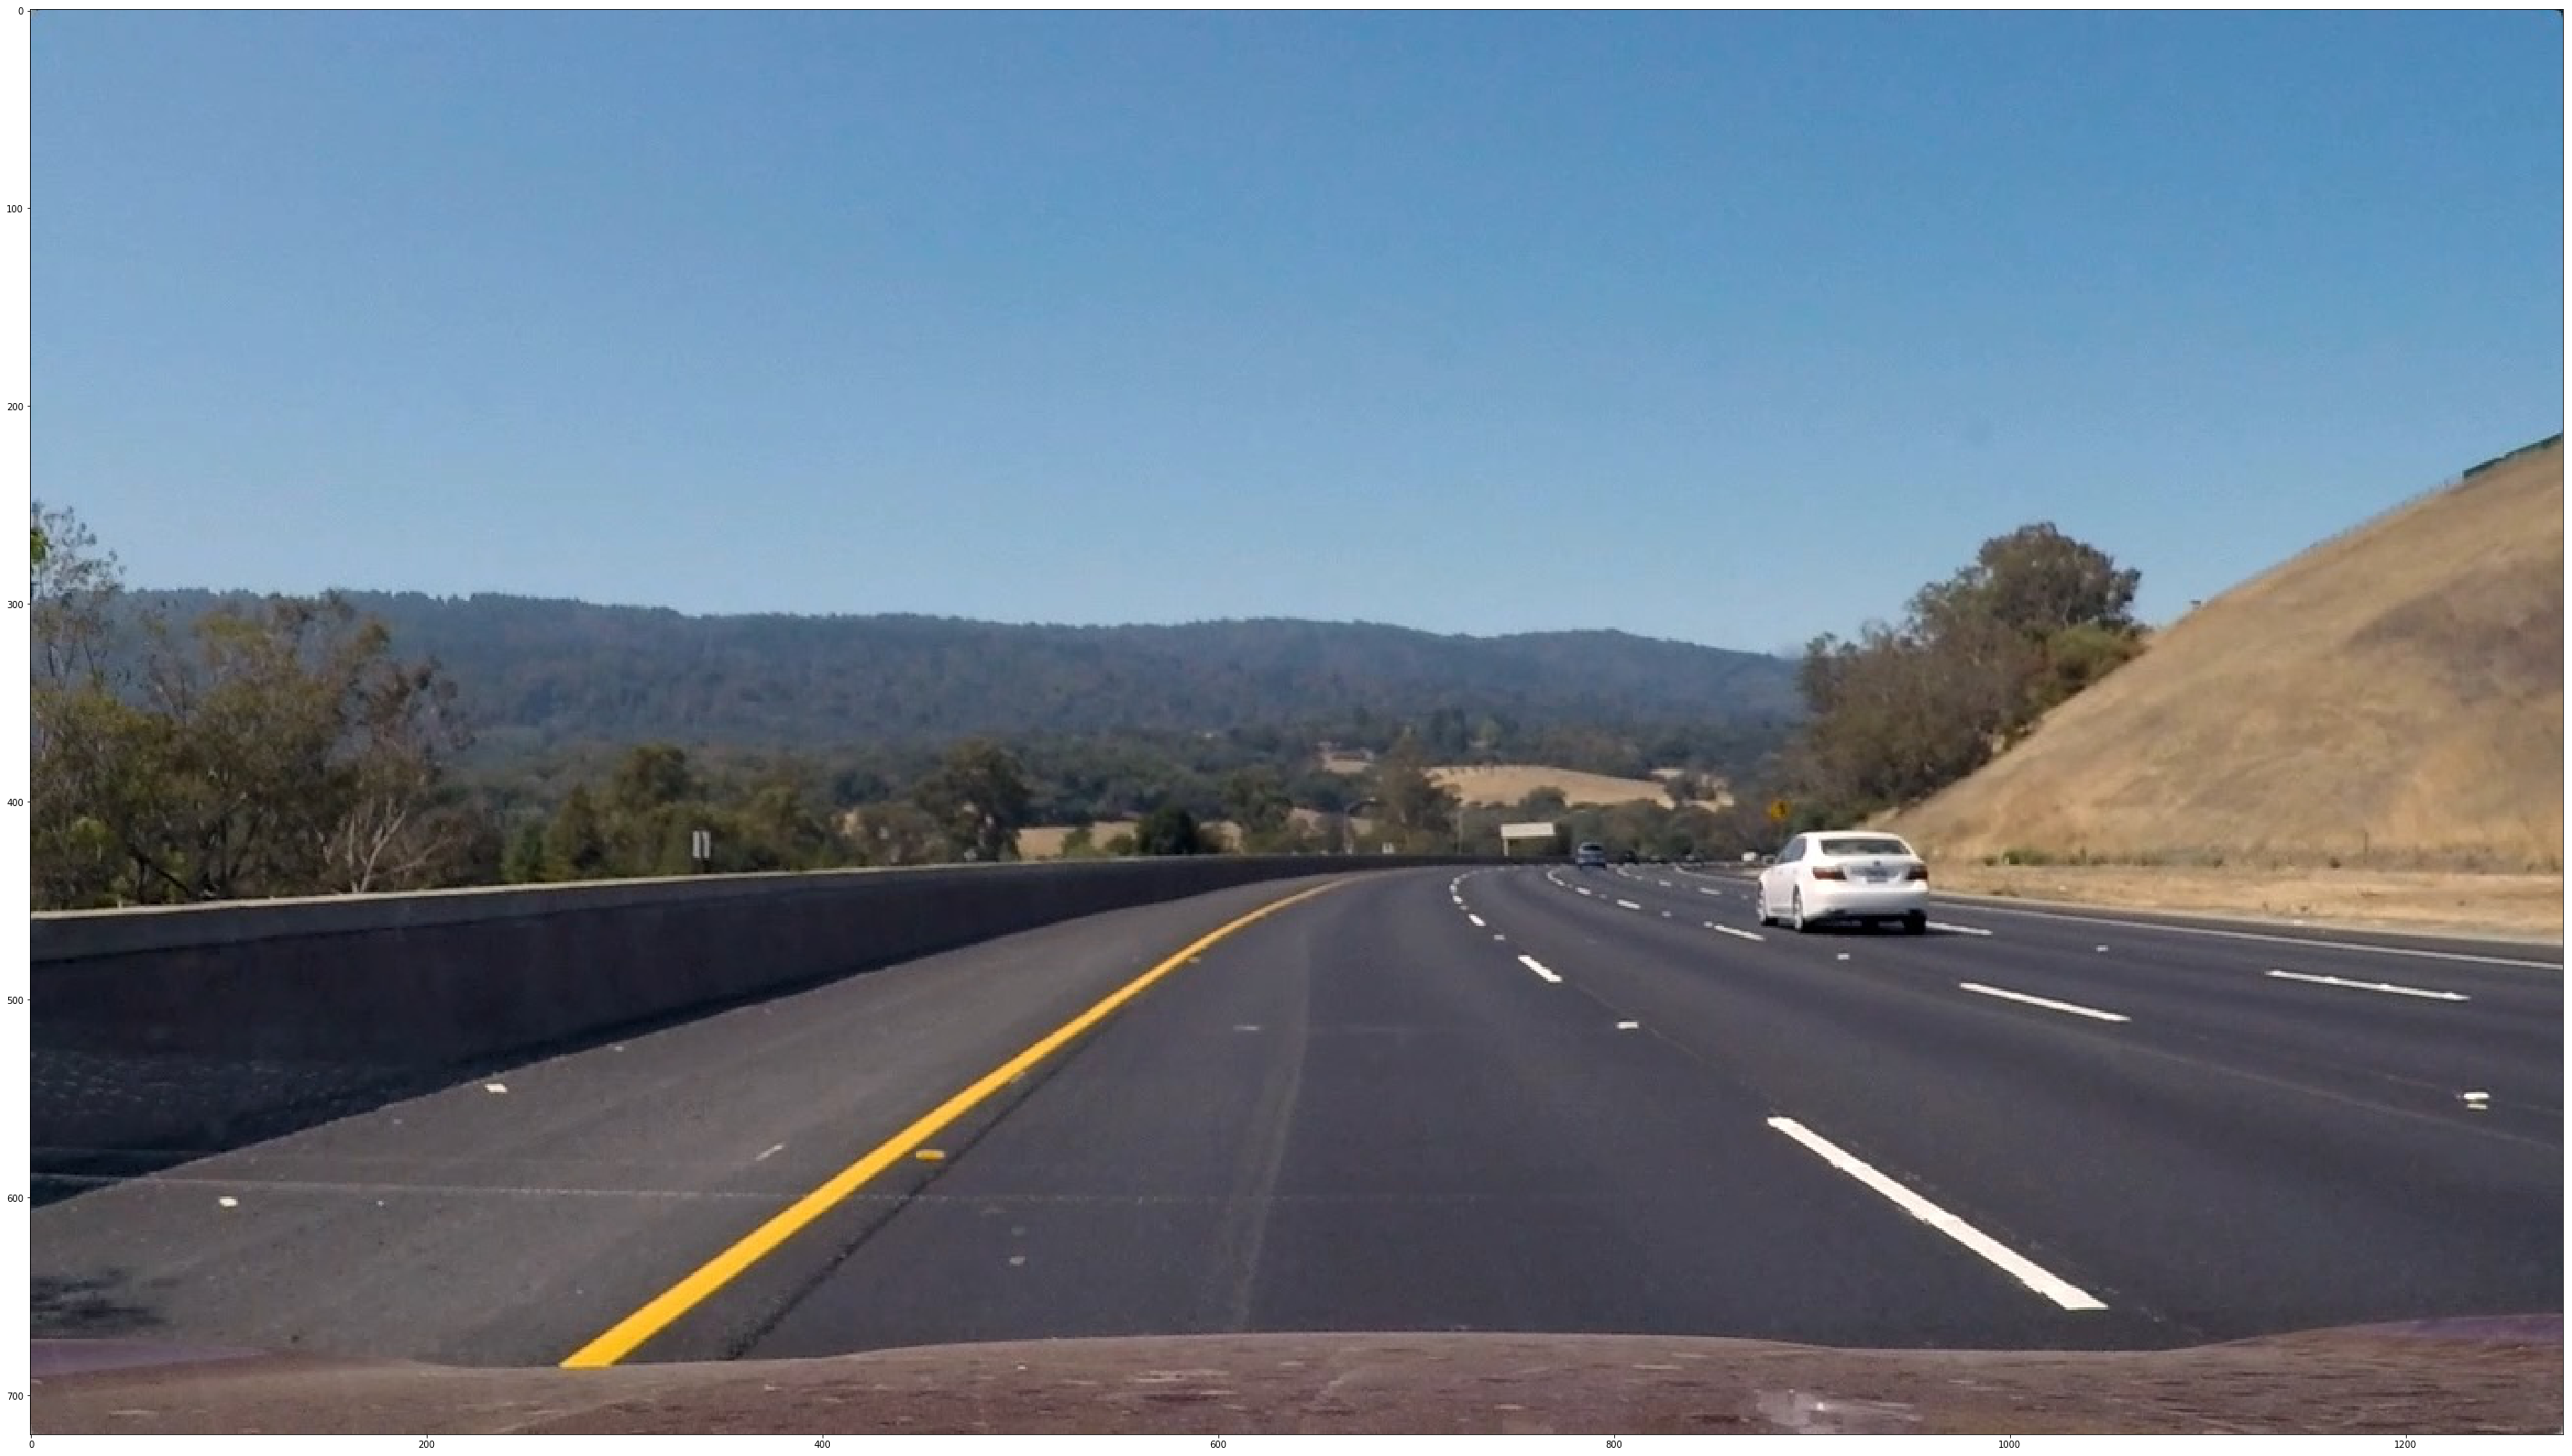

In [33]:
# Get Test image
#orig_image = mpimg.imread('test_images/bbox-example-image.jpg')

orig_image = mpimg.imread('test_images/test3.jpg')
# Copy image for drawing on it
draw_image = np.copy(orig_image)

plt.axis('off')
plt.figure(figsize=(50,50))
plt.imshow(orig_image)



In [34]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color_space(image, cspace)
    
    #3) Compute spatial features if flag is set
    spatial_features = bin_spatial(feature_image, spatial_size)
        
    #4) Append features to list
    img_features.append(spatial_features)
    
    #5) Compute histogram features if flag is set
    hist_features = color_hist(feature_image, hist_bins, bins_range=(0,256))
    
    #6) Append features to list
    img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    #8) Append hog_features to list
    img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


#Extract Iimage features TODO rework
def extract_features_single(image, cspace, spatial_size, hist_bins, 
                     orient, pix_per_cell, cell_per_block, hog_channel):
    features = []
    img_features = []

    #Convert Color
    feature_image = convert_color_space(image, cspace=cspace)


    img_features.append(bin_spatial(feature_image, spatial_size))


    hist_features = color_hist(feature_image, hist_bins, bins_range=(0,256))
    img_features.append(hist_features)

    #HOG Features
    if hog_channel == 'ALL':
        hog_feature = []
        for channel in range(feature_image.shape[2]):
            hog_feature.append(get_hog_features(feature_image[:, :, channel], orient, pix_per_cell,
                                               cell_per_block, vis=False, feature_vec=True))
        hog_feature = np.ravel(hog_feature)
    else:
        hog_feature = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell,
                                      cell_per_block, vis=False, feature_vec=True)
    img_features.append(hog_feature)
    features.append(np.concatenate(img_features))
        
    return features







# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace, spatial_size, hist_bins, hist_range, 
                   orient, pix_per_cell, cell_per_block, hog_channel):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    count = 0
    for window in windows:
        count = count + 1
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        if count == 20:
            test_image = test_img
        #4) Extract features for that window using single_img_features()
        features = extract_features_single(test_img, cspace, spatial_size, hist_bins, 
                                      orient, pix_per_cell, cell_per_block, hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows, test_image



y_start_stop = [500, None] # Min and max in y to search in slide_window()

min_image = orig_image.astype(np.float32)/255

windows = slide_window(min_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))


[]


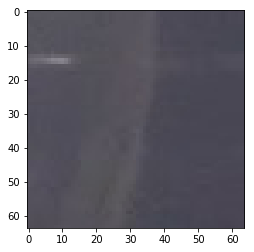

In [35]:
cspace, spatial_size, hist_bins, hist_range = get_parameters_color_features()
cspace, orient, pix_per_cell, cell_per_block, hog_channel = get_parameters_hog_features()

hot_windows, test_image = search_windows(min_image, windows, svc, X_scaler, cspace, spatial_size, hist_bins, hist_range,
                             orient, pix_per_cell, cell_per_block, hog_channel) 
print(hot_windows)
plt.imshow(test_image)



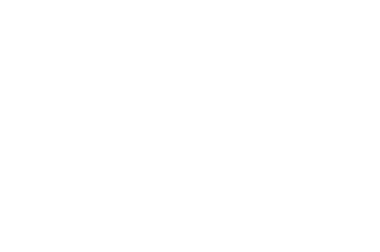

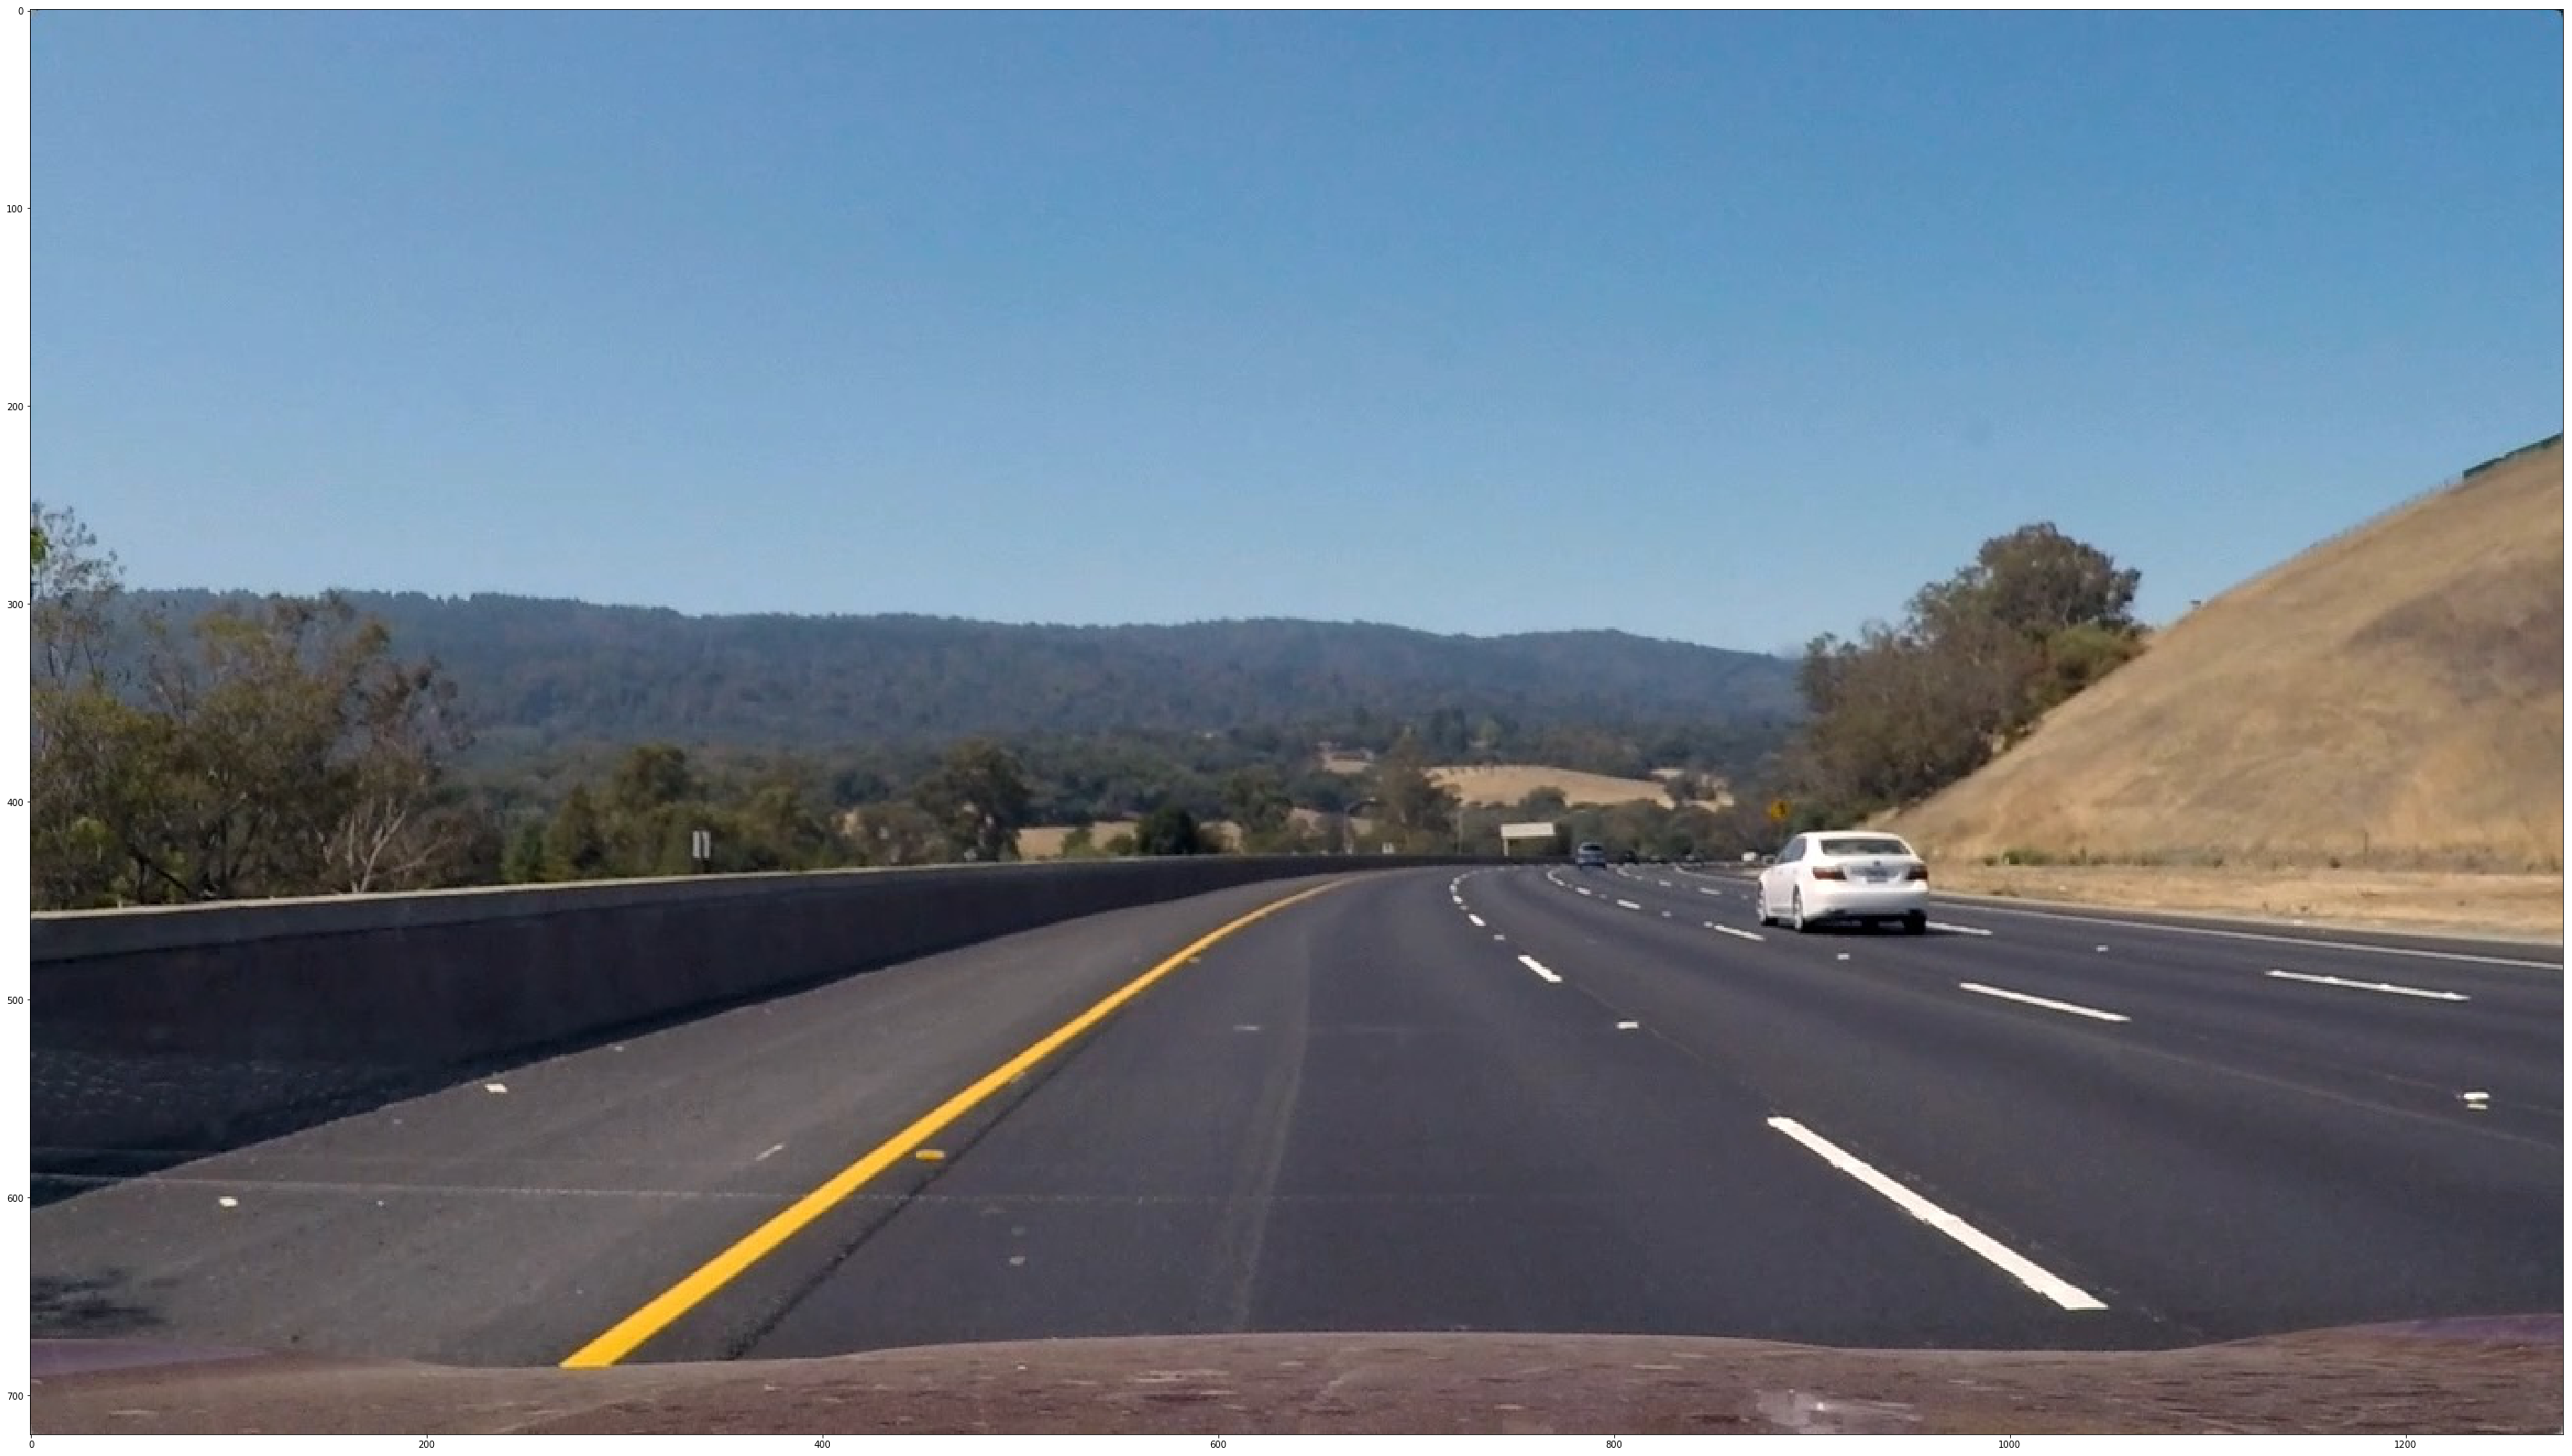

In [36]:
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.axis('off')
plt.figure(figsize=(50,50))
plt.imshow(window_img)
